In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
ClassToNum = {
    'hospitalized' : 0,
    'nonhospitalized' : 1,
    'recovered' : 2,
    'deceased' : 3
}

NumToClass = {v: k for k, v in ClassToNum.items()}

labels = ['hospitalized', 'nonhospitalized', 'recovered', 'deceased']

def printScore(y_true, y_pred, avg):
    print('Precision:', precision_score(y_true, y_pred, average = avg))
    print('Recall:', recall_score(y_true, y_pred, average = avg))
    for label, score in zip(labels, f1_score(y_true, y_pred, average = None, labels = [0,1,2,3])):
        print('F1 score for ', label, ':', score)

In [3]:
data = pd.read_csv("dataset/milestone1.csv")
pd.set_option('display.max_columns', None)

## Convert categorical columns to numerical by Label Encoding

In [4]:
data['Province_State'] = data['Province_State'].astype('category').cat.codes
data['Country_Region'] = data['Country_Region'].astype('category').cat.codes
data['date_confirmation'] = data['date_confirmation'].astype('category').cat.codes
data['sex'] = data['sex'].astype('category').cat.codes
data = data.replace({"outcome": ClassToNum})

# 2.1 Split data into training and test datasets with ratio 0.8 : 0.2

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['outcome']), data['outcome'], test_size = 0.2)

# 2.2 Build Model - Light GBM

### Train a LGB model and save as lgb_model.pkl

In [6]:
lgb = LGBMClassifier(num_leaves = 200, objective = 'multiclass').fit(X_train, y_train)

In [7]:
# Save to folder

# with open("models/lgb_model.pkl", 'wb') as file:
#     pickle.dump(lgb, file)

# 2.3 Evaluation

In [8]:
# Load model from file

# with open("models/lgb_model.pkl", 'rb') as file:
#     lgb = pickle.load(file)

### LGB model accuracy score on both Train and Test Sets.

In [9]:
train_predictions = lgb.predict(X_train)
test_predictions = lgb.predict(X_test)
print('Accuracy on Training Set:', accuracy_score(y_train, train_predictions))
print('Accuracy on Test Set:', accuracy_score(y_test, test_predictions))

Accuracy on Training Set: 0.8793999654016295
Accuracy on Test Set: 0.8744137514415948


## F1 score on individual class of both Train and Test Sets.

In [10]:
print('Training Set')
printScore(y_train, train_predictions, 'weighted')
print('\nTest Set')
printScore(y_test, test_predictions, 'weighted')

Training Set
Precision: 0.8811498937688654
Recall: 0.8793999654016295
F1 score for  hospitalized : 0.8726555949456466
F1 score for  nonhospitalized : 0.999964712939765
F1 score for  recovered : 0.683222298916542
F1 score for  deceased : 0.17073717230562402

Test Set
Precision: 0.8722768250490937
Recall: 0.8744137514415948
F1 score for  hospitalized : 0.8681645658591443
F1 score for  nonhospitalized : 0.9997336466901684
F1 score for  recovered : 0.6667714258776202
F1 score for  deceased : 0.08133086876155268


## Confusion Matrix for Training Set

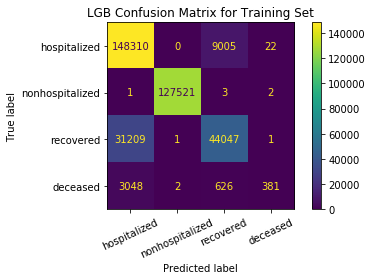

In [11]:
disp = plot_confusion_matrix(lgb, X_train, y_train, display_labels = labels, xticks_rotation = 25)
disp.ax_.set_title('LGB Confusion Matrix for Training Set')
plt.tight_layout()
# plt.savefig('plots/lgb_cm_train.png')

## Confusion Matrix for Test Set

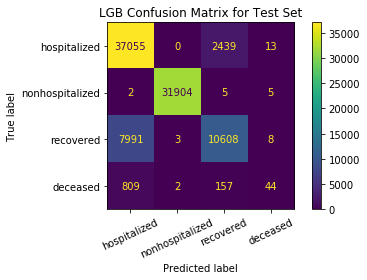

In [12]:
disp = plot_confusion_matrix(lgb, X_test, y_test, display_labels = labels, xticks_rotation = 25)
disp.ax_.set_title('LGB Confusion Matrix for Test Set')
plt.tight_layout()
# plt.savefig('plots/lgb_cm_test.png')

## ROC curve for each individual class

In [13]:
y_scores = lgb.predict_proba(X_test)

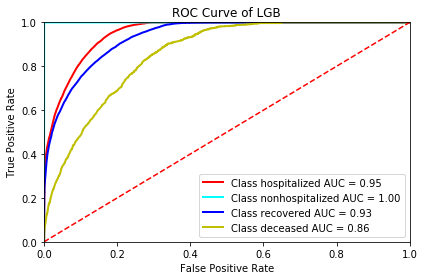

In [14]:
colors = ['r', 'aqua', 'b', 'y']

for i in range(4):
    y = []
    y[:] = [1 if x == i else 0 for x in y_test]

    fpr, tpr, threshold = roc_curve(y, y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, colors[i], linewidth=2, label = f'Class {NumToClass[i]} AUC = %0.2f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of LGB')
plt.tight_layout()
# plt.savefig('plots/lgb_roc.png')
plt.show()

# 2.4 Overfitting

### Train LGB models using different values of min_child_samples

In [15]:
score = pd.DataFrame(columns = ['Training Set', 'Test Set'])
for i in [1,10,15,25,40]:
    clf = LGBMClassifier(num_leaves = 1000, min_child_samples = i, n_estimators = 1, 
                         objective = 'multiclass').fit(X_train, y_train)
    score.loc[i] = [1-accuracy_score(y_train, clf.predict(X_train)), 1-accuracy_score(y_test, clf.predict(X_test))]

### Notice the classfication error increases on test set and deceases on training set when min_child_samples gets smaller (<10)  This is evidence of overfitting

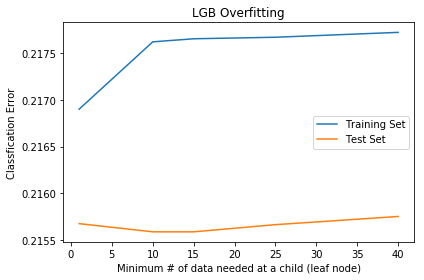

In [16]:
plt.plot(score['Training Set'], label = 'Training Set')
plt.plot(score['Test Set'], label = 'Test Set')
plt.legend()
plt.title('LGB Overfitting')
plt.xlabel('Minimum # of data needed at a child (leaf node)')
plt.ylabel('Classfication Error')
plt.tight_layout()
# plt.savefig('plots/lgb_overfitting.png')
plt.show()

# KNN

# 2.2 Build Model - KNN

### Train a KNN model and save as knn_model.pkl. The following code may run for 2 minutes

In [17]:
knn = KNeighborsClassifier(n_neighbors = 10).fit(X_train, y_train)

In [18]:
# Save to folder

# with open("models/knn_model.pkl", 'wb') as file:
#     pickle.dump(knn, file)

# 2.3 Evaluation

In [19]:
# Load model from file

# with open("models/knn_model.pkl", 'rb') as file:
#     knn = pickle.load(file)

### KNN model accuracy score on both Train and Test Sets. The following code may run for 1 minutes

In [20]:
train_predictions = knn.predict(X_train)
test_predictions = knn.predict(X_test)
print('Accuracy on Training Set:', accuracy_score(y_train, train_predictions))
print('Accuracy on Test Set:', accuracy_score(y_test, test_predictions))

Accuracy on Training Set: 0.8694295936888179
Accuracy on Test Set: 0.8645944313251689


## F1 score on individual class of both Train and Test Sets.

In [21]:
print('Training Set')
printScore(y_train, train_predictions, 'weighted')
print('\nTest Set')
printScore(y_test, test_predictions, 'weighted')

Training Set
Precision: 0.8663585997253163
Recall: 0.8694295936888179
F1 score for  hospitalized : 0.8595215830593345
F1 score for  nonhospitalized : 0.9994042066148744
F1 score for  recovered : 0.6766392130613196
F1 score for  deceased : 0.08080336291452592

Test Set
Precision: 0.8604029313418112
Recall: 0.8645944313251689
F1 score for  hospitalized : 0.8548970590002765
F1 score for  nonhospitalized : 0.9993108848864526
F1 score for  recovered : 0.6602513169123921
F1 score for  deceased : 0.05871212121212121


## Confusion Matrix for Training Set. The following code may run +1 minutes

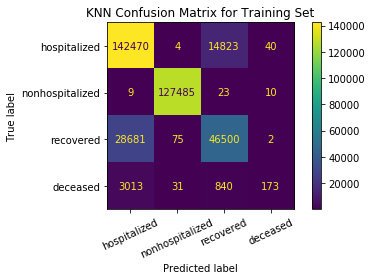

In [22]:
disp = plot_confusion_matrix(knn, X_train, y_train, display_labels = labels, xticks_rotation = 25)
disp.ax_.set_title('KNN Confusion Matrix for Training Set')
plt.tight_layout()
# plt.savefig('plots/knn_cm_train.png')

## Confusion Matrix for Test Set

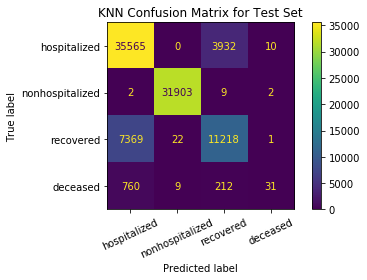

In [23]:
disp = plot_confusion_matrix(knn, X_test, y_test, display_labels = labels, xticks_rotation = 25)
disp.ax_.set_title('KNN Confusion Matrix for Test Set')
plt.tight_layout()
# plt.savefig('plots/knn_cm_test.png')

## ROC curve for each individual class

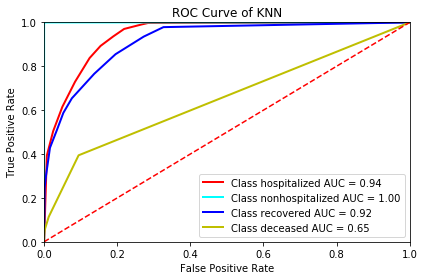

In [24]:
# AUC
y_scores = knn.predict_proba(X_test)
colors = ['r', 'aqua', 'b', 'y']

for i in range(4):
    y = []
    y[:] = [1 if x == i else 0 for x in y_test]

    fpr, tpr, threshold = roc_curve(y, y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, colors[i], linewidth=2, label = f'Class {NumToClass[i]} AUC = %0.2f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of KNN')
plt.tight_layout()
# plt.savefig('plots/knn_roc.png')
plt.show()

# 2.4 Overfitting  - Did not observe overfitting for KNN

### Train KNN models using different values of n_neighbors. 

## The following code run +30 minutes

In [25]:
# score = pd.DataFrame(columns = ['Training Set', 'Test Set'])
# for i in [1,2,3,4,5,10,20,40,80,200]:
#     clf = KNeighborsClassifier(n_neighbors = i, algorithm = 'ball_tree', leaf_size = 10000).fit(X_train, y_train)
#     score.loc[i] = [1-clf.score(X_train, y_train), 1-clf.score(X_test, y_test)]

In [26]:
# plt.plot(score['Training Set'], label = 'Training Set')
# plt.plot(score['Test Set'], label = 'Test Set')
# plt.legend()
# plt.title('KNN Overfitting')
# plt.xlabel('k neighbors')
# plt.ylabel('Classfication Error')
# plt.tight_layout()
# plt.savefig('plots/knn_overfitting.png')
# plt.show()